In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [13]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
batch_size = 128

In [15]:
trainset = datasets.MNIST(root='./data/',
                 train=True,
                 transform=transforms.ToTensor(),
                 download=True)

testset = datasets.MNIST(root='./data/',
                train=False,
                transform=transforms.ToTensor(),
                download=True)

train_loader = DataLoader(dataset=trainset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=testset,
                         batch_size=104,
                         shuffle=False)


In [ ]:
def imq_kernel(X: torch.Tensor,
               Y: torch.Tensor,
               h_dim: int):
    batch_size = X.size(0)

    norms_x = X.pow(2).sum(1, keepdim=True)  # batch_size x 1
    prods_x = torch.mm(X, X.t())  # batch_size x batch_size
    dists_x = norms_x + norms_x.t() - 2 * prods_x

    norms_y = Y.pow(2).sum(1, keepdim=True)  # batch_size x 1
    prods_y = torch.mm(Y, Y.t())  # batch_size x batch_size
    dists_y = norms_y + norms_y.t() - 2 * prods_y

    dot_prd = torch.mm(X, Y.t())
    dists_c = norms_x + norms_y.t() - 2 * dot_prd

    stats = 0
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = 2 * h_dim * 1.0 * scale
        res1 = C / (C + dists_x)
        res1 += C / (C + dists_y)

        if torch.cuda.is_available():
            res1 = (1 - torch.eye(batch_size).cuda()) * res1
        else:
            res1 = (1 - torch.eye(batch_size)) * res1

        res1 = res1.sum() / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum() * 2. / (batch_size)
        stats += res1 - res2

    return stats


In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_channel, dim_h, n_z):
        super(Encoder, self).__init__()

        self.n_channel = n_channel
        self.dim_h = dim_h
        self.n_z = n_z

        self.main = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.main(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_channel, dim_h, n_z):
        super(Decoder, self).__init__()

        self.n_channel = n_channel
        self.dim_h = dim_h
        self.n_z = n_z

        self.proj = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.proj(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.main(x)
        return x

In [18]:
lr = 0.0001
sigma = 1
n_z = 8
epochs = 100

In [19]:
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from tqdm import tqdm

In [ ]:
encoder, decoder = Encoder(n_channel=1, n_z=n_z, dim_h=128), Decoder(n_channel=1, n_z=n_z, dim_h=128)
criterion = nn.MSELoss()

encoder.train()
decoder.train()

if torch.cuda.is_available():
    encoder, decoder = encoder.cuda(), decoder.cuda()

one = torch.Tensor([1])
mone = one * -1

if torch.cuda.is_available():
    one = one.cuda()
    mone = mone.cuda()

# Optimizers
enc_optim = optim.Adam(encoder.parameters(), lr=lr)
dec_optim = optim.Adam(decoder.parameters(), lr=lr)

enc_scheduler = StepLR(enc_optim, step_size=30, gamma=0.5)
dec_scheduler = StepLR(dec_optim, step_size=30, gamma=0.5)

for epoch in range(epochs):
    step = 0
    for (images, _) in tqdm(train_loader):

        if torch.cuda.is_available():
            images = images.cuda()

        enc_optim.zero_grad()
        dec_optim.zero_grad()

        # ======== Train Generator ======== #

        batch_size = images.size()[0]

        z = encoder(images)
        x_recon = decoder(z)

        recon_loss = criterion(x_recon, images)

        # ======== MMD Kernel Loss ======== #

        z_fake = Variable(torch.randn(images.size()[0], n_z) * sigma)
        if torch.cuda.is_available():
            z_fake = z_fake.cuda()

        z_real = encoder(images)

        mmd_loss = imq_kernel(z_real, z_fake, h_dim=encoder.n_z)
        mmd_loss = mmd_loss / batch_size

        total_loss = recon_loss + mmd_loss
        total_loss.backward()

        enc_optim.step()
        dec_optim.step()

        step += 1

        if (step + 1) % 300 == 0:
            print("Epoch: [%d/%d], Step: [%d/%d], Reconstruction Loss: %.4f, MMD Loss %.4f" %
                  (epoch + 1, epochs, step + 1, len(train_loader), recon_loss.data.item(),
                   mmd_loss.item()))

    if (epoch + 1) % 1 == 0:
        val_batch_size = 25

        z_sample = torch.randn(val_batch_size, 8).cuda()
        sample = decoder(z_sample).cpu().view(val_batch_size, 1, 28, 28)

        # draw sample using plt

        fig = plt.figure(figsize=(20, 20))
        for i in range(25):
            ax = fig.add_subplot(5, 5, i + 1)
            ax.imshow(sample[i].view(28, 28).detach().cpu().numpy(), cmap='gray')
            ax.axis('off')
        plt.show()


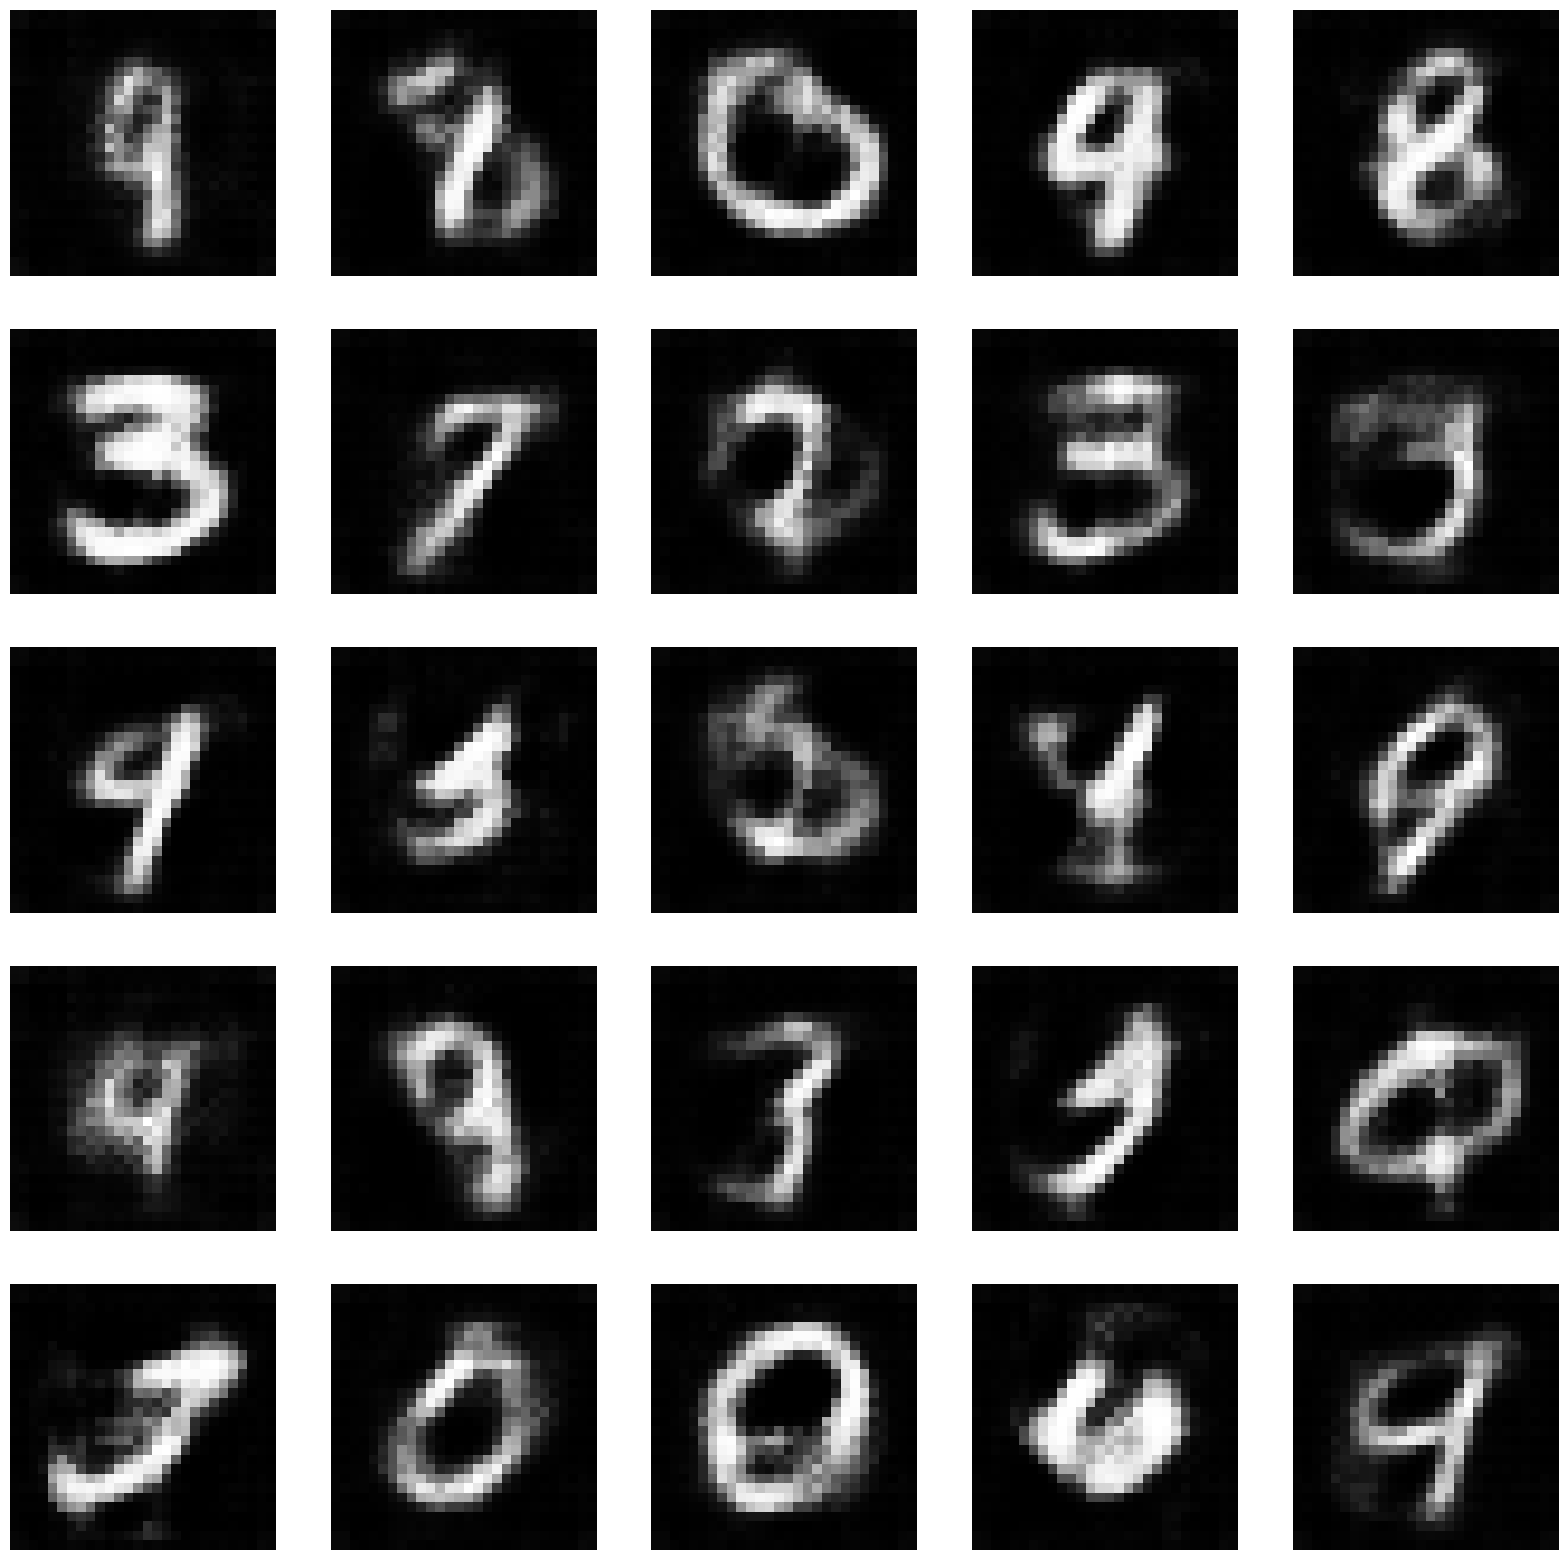